# Drought Termination in CMIP6

What this notebook does:
1. Plots drought responses across multiple models
2. Plots drought indexes across multiple models
3. Identifies drought events across multiple models

## Setup

### Necessary Packages

In [1]:
# data import
import zarr
import fsspec
import intake
from dask.diagnostics import ProgressBar

# data analysis
import numpy as np
import pandas as pd
import xarray as xr
import dask 
import xesmf as xe
xr.set_options(display_style='html')
import cftime

import glob


import warnings
warnings.filterwarnings("ignore")

# progress bars for loops
from tqdm.notebook import tqdm  

# plotting
import regionmask

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)

from IPython import display
display.set_matplotlib_formats('retina')

import sys,os
sys.path.append("../python-utils")

### Helper Functions for Data Import

In [2]:
def get_rawdir(variable):
    if variable in os.listdir("/home/kdm2144/DROUGHT/DOWNLOADED_RAW/"):
        rawdir="/home/kdm2144/DROUGHT/DOWNLOADED_RAW/"+variable+"/"
    elif variable in os.listdir("/home/kdm2144/DROUGHT/PROCESSED/"):
        rawdir="/home/kdm2144/DROUGHT/PROCESSED/"+variable+"/"
    else:
        raise TypeError("No directory found for",variable)
    return rawdir

def get_models(variable):
    direc = get_rawdir(variable)
    models = sorted(os.listdir(direc))
    return models

def get_filenames_old(model,variable,experiment,member_id):
    rawdir=get_rawdir(variable)
    return sorted(glob.glob(rawdir+model+"/*."+experiment+".*"+member_id+".*"))

def check_availability(curr_mod,curr_var,experiment_id):
    # ingrid_cmip6 is defined as a global variable rather 
    # than opening it here every single time 
    # ingrid_cmip6 = pd.read_csv("mary_cmip6.csv")
    df1 = ingrid_cmip6[(ingrid_cmip6.source_id==curr_mod)                      
                       & (ingrid_cmip6.variable_id==curr_var)                       
                       & (ingrid_cmip6.experiment_id == experiment_id)]
    return(df1)

def get_members_old(curr_mod, curr_var, experiment_id):
    """ 
    returns an array of unique member_ids for a given model, variable, and experiment
    """
    df1 = check_availability(curr_mod, curr_var, experiment_id)
    return(np.unique(df1.member_id))

def get_filenames(model, member_id):
    fnames = []
    for variable in variables:
        rawdir=get_rawdir(variable)
        for experiment in experiments:
            fnames.append(glob.glob(rawdir+model+"/*."+experiment+".*"+member_id+".*"))
    return sorted(fnames)

def get_members(model):
    members = ingrid_cmip6[ingrid_cmip6['variable_id'].isin(variables) 
             & ingrid_cmip6['experiment_id'].isin(experiments)
             & ingrid_cmip6['source_id'].eq(model)].member_id.unique()
    return members

def fix_lon(ds):
    '''
    adjust longitude to be [-180, 180]
    '''
    ds = ds.copy()
    
    ## TO DO FIGURE OUT HOW TO KEEP LONGITUDE ATTRIBUTES 
    if ds.lon.max()>180:
        ds.coords['lon'] = ((ds.coords['lon'] + 180) % 360 - 180) 
        ds = ds.sortby(ds.lon)

    return ds

def preprocess_dims(ds):
    """
    Raw Data from home/kdm2144/DROUGHT/DOWNLOADED_RAW/ has "axis_" followed by a string of numbers for the time variable. 
    This small loop renames that dimension as time to allow xarray to open and combine each year of data. 
    Adds additional information about member_id and experiment.
    """
    
    ## this should maybe include something that deals with the length? that might make the models play nicer together 
    
    for dim in ds.dims:
        if 'axis_' in dim:
            ds = ds.rename({dim: 'time'})
     
    member_id = ds.encoding['source'].split('.')[-3]
    experiment = ds.encoding['source'].split('.')[1]

    ds = fix_lon(ds)
    ds = ds.assign_coords(member_id = member_id, experiment = experiment)

    return ds

### Helper Functions for Data Analsysis

In [3]:
### GLOBAL MEANS ###

def get_lat_name(ds):
    for lat_name in ['lat', 'latitude']:
        if lat_name in ds.coords:
            return lat_name
    raise RuntimeError("Couldn't find a latitude coordinate")

def global_mean(ds):
    """
    Calculate weighted global mean average
    """
    lat = ds[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ds.dims) - {'time'} - {'year'} -{'member_id'}
    return (ds * weight).mean(other_dims)

def region_select(ds, region_params):
    """
    subset a dataset by region
    """
    region_ds = ds.sel(lat=slice(*region_params['lat']), lon=slice(*region_params['lon']))
    return region_ds

### Data Import 


First, define some global variables, these are the experiments and variables of interest.

In [4]:
global variables 
variables = ['mrsos', 'tas', 'pr']
global experiments 
experiments = ['historical', 'ssp585'] #['historical', 'ssp126', 'ssp585']
global ingrid_cmip6
ingrid_cmip6 = pd.read_csv("mary_cmip6.csv")

# these are just the models pulled from Pangeo, need to do a model check to see what additional ones are available 
# in dester, but just working with these for now to start. 
global models
models = ['BCC-CSM2-MR', #'MIROC6', 'ACCESS-ESM1-5',
          'CanESM5-CanOE', 'CESM2-WACCM', 'FIO-ESM-2-0',
          'MIROC-ES2L', 'UKESM1-0-LL', 'ACCESS-CM2',
          'CAMS-CSM1-0' ] #, 'CanESM5']
           #'MPI-ESM1-2-LR','MPI-ESM1-2-HR','MRI-ESM2-0',

In [5]:
def model_import_old(models, variable, experiments):
    ddict = {}
    for model in tqdm(models):
        print('starting ' + model)
        tmp = []
        for experiment in experiments:
            fname = []
            member_ids = get_members(model, variable, experiment)
            for member in member_ids:
                fname.append(get_filenames(model, variable, experiment, member))
            tmp.append(xr.open_mfdataset(fname, combine = 'nested', concat_dim = ['member_id', 'time'],  
                                     preprocess = preprocess_dims))

        ddict[model] = xr.concat(tmp, dim = 'member_id')
    return ddict

In [6]:
#def get_filenames(model, member_id):
#    fnames = []
#    for variable in variables:
#        rawdir=get_rawdir(variable)
#        for experiment in experiments:
#            fnames.append(glob.glob(rawdir+model+"/*."+experiment+".*"+member_id+".*"))
#    return sorted(fnames)

In [7]:
# temporary because of an issue with referencing from the csv
models = ['BCC-CSM2-MR', 'CanESM5-CanOE', 'CESM2-WACCM', 'FIO-ESM-2-0']

ddict = dict.fromkeys(models, {})

for model in tqdm(ddict.keys()):
    print("starting " + model)
    member_ids = get_members(model)
    for member_id in member_ids:
        fnames = get_filenames(model, member_id)
        ddict[model][member_id] = xr.open_mfdataset(fnames, preprocess = preprocess_dims)


  0%|          | 0/4 [00:00<?, ?it/s]

starting BCC-CSM2-MR
starting CanESM5-CanOE
starting CESM2-WACCM
starting FIO-ESM-2-0


## Spatial responses over select region 

I'm using 1861-1880 for the base period (decent temperature record coverage, GHGs almost at preindustrial, no annoying volcanoes).

In [8]:
# define region
region_params = {'lat':[25,55],'lon':[-15, 45]}

In [9]:
def responses(ds):
    """
    Calculate difference between early and late period.
    Lazy.
    """

    ds = ds.copy()
    
    early_start = '1861'
    early_end = '1880'
    early = ds.sel(time=slice(early_start, early_end)).mean(dim = 'time')
    
    late_start = '2050'
    late_end = '2100'
    late = ds.sel(time = slice(late_start, late_end)).mean(dim = 'time')
    
    difference = (late - early)/early.std()
    
    return difference

In [10]:
models = ['BCC-CSM2-MR', 'CanESM5-CanOE', 'CESM2-WACCM', 'FIO-ESM-2-0']
model_responses = dict.fromkeys(models, {})

for model in tqdm(model_responses.keys()):
    print('starting ' + model)
    for member_id in ddict[model].keys():
        #print(member_id)
        model_responses[model][member_id] = responses(region_select(ddict[model][member_id], region_params))

  0%|          | 0/4 [00:00<?, ?it/s]

starting BCC-CSM2-MR
starting CanESM5-CanOE
starting CESM2-WACCM
starting FIO-ESM-2-0


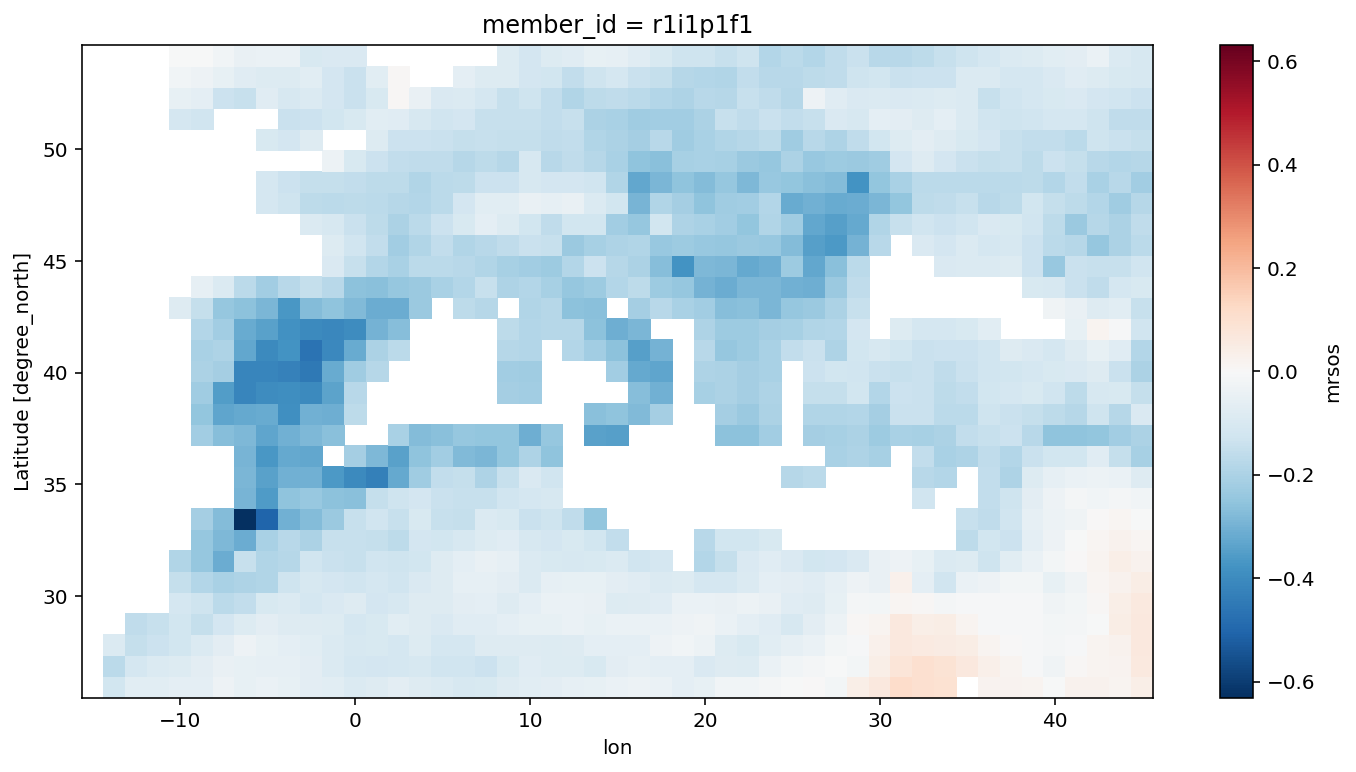

In [11]:
model_responses['BCC-CSM2-MR']['r1i1p1f1'].mrsos.plot()

In [ ]:
nrows = 3
ncols = 4

fig, axarr = plt.subplots(nrows = nrows, ncols = ncols, figsize = [25, 15], subplot_kw={"projection": ccrs.Robinson()})

for ax, model in zip(axarr.flat, model_responses.keys()):
    #print('starting ' + model)
    sms = model_responses[model].mrsos.mean(dim = 'member_id').plot(cmap = 'BrBG', transform=ccrs.PlateCarree(), ax = ax, add_colorbar = False)

    gl = ax.gridlines(draw_labels=True, dms=True, 
                 x_inline=False, y_inline=False, 
                 zorder = 3)

    gl.top_labels = False
    gl.right_labels = False

    ax.add_feature(cfeature.OCEAN, zorder = 2, facecolor = '0.9')
    ax.coastlines(zorder = 3)
    ax.set_title(model, y = 1.15)
    
### [left/right, up/down, , size]    
#cbar_ax_sms = fig.add_axes([0.92, 0.67, 0.015, 0.2])
cbar_ax_sms = fig.add_axes([0.92, 0.3, 0.015, 0.5])
fig.colorbar(sms, cax = cbar_ax_sms, label = 'Surface Soil Moisture')

plt.tight_layout()

In [ ]:
for model in model_responses.keys():
    for member_id in model_responses[model].keys():
        

## Drought Index 

In [12]:
model_anoms = dict.fromkeys(models, {})

for model in tqdm(model_anoms.keys()):
    print('starting ' + model)
    for member_id in ddict[model].keys():
        ds = region_select(ddict[model][member_id], region_params)
        ## this is hackish and should be fixed to something more reliable 
        ## to eliminate the ensemble members that don't go across the entire time period
        if len(ds.time) < 2000:
            model_anoms[model][member_id] = np.nan
        else:
            # flagging for baseline sensitivity tense
            baseline = ds.sel(time = slice('1861', '1880')).groupby('time.month')
            ds_standard = (ds.groupby('time.month') - baseline.mean())/baseline.std()
            ds_anom = global_mean(ds_standard)
            model_anoms[model][member_id] = ds_anom
            

  0%|          | 0/4 [00:00<?, ?it/s]

starting BCC-CSM2-MR
starting CanESM5-CanOE
starting CESM2-WACCM
starting FIO-ESM-2-0


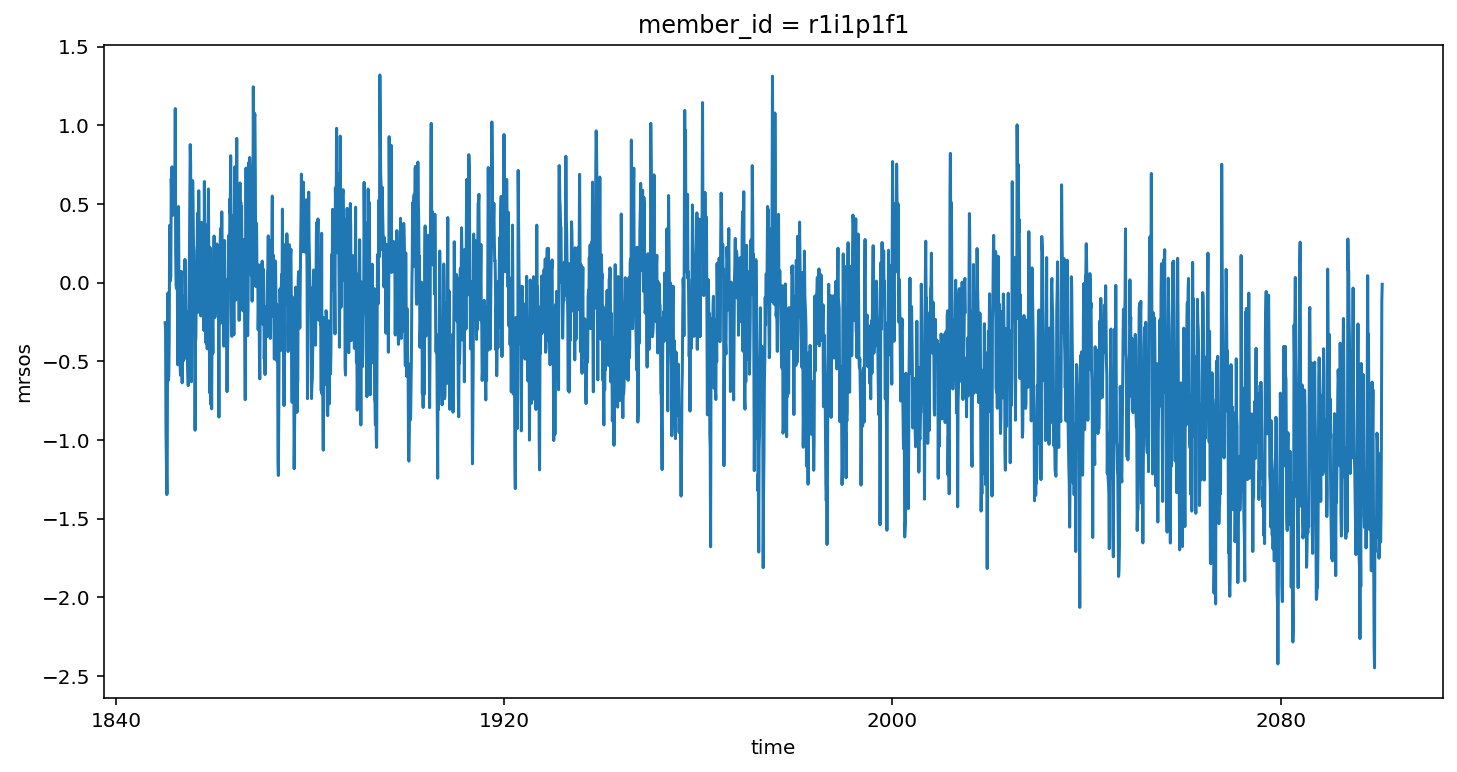

In [13]:
model_anoms['BCC-CSM2-MR']['r1i1p1f1'].mrsos.plot()

## Drought Detection

First, let's load everything into memory. This will take a while because xarray is slow...

In [14]:
model_anoms['BCC-CSM2-MR']['r1i1p1f1'].mrsos

<xarray.DataArray 'mrsos' (time: 3014)>
dask.array<mean_agg-aggregate, shape=(3014,), dtype=float32, chunksize=(2,), chunktype=numpy.ndarray>
Coordinates:
  * time        (time) object 1850-01-16 11:44:59.972534 ... 2100-12-16 12:00:00
    member_id   <U8 'r1i1p1f1'
    experiment  (time) object 'historical' 'historical' ... 'ssp585' 'ssp585'

In [15]:
%time model_anoms['BCC-CSM2-MR']['r1i1p1f1'].mrsos.load()

CPU times: user 1min 21s, sys: 12.4 s, total: 1min 34s
Wall time: 1min 17s


<xarray.DataArray 'mrsos' (time: 3014)>
array([-0.17856844,         nan, -0.2534712 , ..., -1.0011301 ,
       -0.11505838, -0.009242  ], dtype=float32)
Coordinates:
  * time        (time) object 1850-01-16 11:44:59.972534 ... 2100-12-16 12:00:00
    member_id   <U8 'r1i1p1f1'
    experiment  (time) object 'historical' 'historical' ... 'ssp585' 'ssp585'

In [23]:
model_anoms['BCC-CSM2-MR'].keys()

dict_keys(['r1i1p1f1', 'r3i1p1f1', 'r2i1p1f1', 'r1i1p2f1', 'r3i1p2f1', 'r2i1p2f1', 'r5i1p1f1', 'r4i1p1f1'])

In [21]:
model_anoms_mrsos_r = dict.fromkeys(models, {})

for model in tqdm(model_anoms.keys()):
    print('starting ' + model)
    for member_id in model_anoms[model].keys(): 
        print('starting ' + member_id)
        model_anoms_mrsos_r[model][member_id] = model_anoms[model][member_id].mrsos.load()
        #model_anoms[model][member_id].load()

  0%|          | 0/4 [00:00<?, ?it/s]

starting BCC-CSM2-MR
starting r1i1p1f1
starting r3i1p1f1
starting r2i1p1f1
starting r1i1p2f1
starting r3i1p2f1
starting r2i1p2f1
starting r5i1p1f1


AttributeError: 'float' object has no attribute 'mrsos'

In [26]:
model_anoms_mrsos_r.keys()

dict_keys(['BCC-CSM2-MR', 'CanESM5-CanOE', 'CESM2-WACCM', 'FIO-ESM-2-0'])

CPU times: user 49.5 ms, sys: 5.21 ms, total: 54.7 ms
Wall time: 52.2 ms


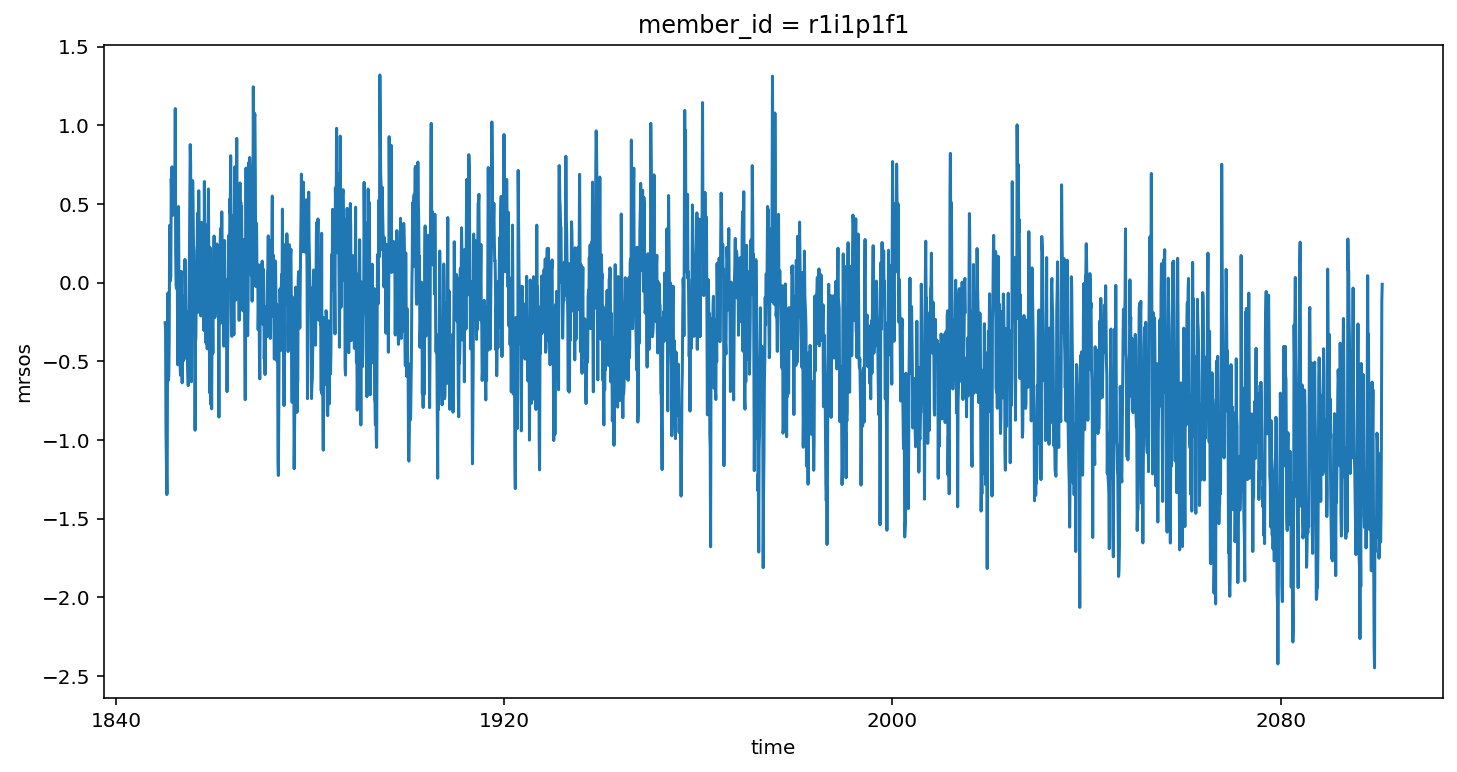

In [25]:
%time model_anoms_mrsos_r['BCC-CSM2-MR']['r1i1p1f1'].plot()

In [27]:
## 3 month Rolling Mean
model_anoms_r = dict.fromkeys(models, {})

for model in tqdm(model_anoms_r.keys()):
    print('starting' + model)
    for member_id in model_anoms_mrsos_r[model].keys():
        model_anoms_r[model][member_id] = model_anoms_mrsos_r[model][member_id].rolling(time = 3, center = False).mean()

        # Creating a Mask/for 3 month drought means

        #point5_sd = model_anoms_r[model][member_id].mrsos <= -0.5
        point5_sd = model_anoms_r[model][member_id] <= -0.5

        point5_sd_mask = point5_sd.to_masked_array()
        point5_sd_mask.mask = ~point5_sd
        point5_sd_trues = np.ma.notmasked_contiguous(point5_sd_mask)

        for slices in point5_sd_trues:
            if (slices.stop - slices.start < 5):
                #point5_sd[slices].values = False
                point5_sd[slices] = False

        #one_sd = model_anoms_r[model][member_id].mrsos <= -1
        one_sd = model_anoms_r[model][member_id] <= -1

        one_sd_mask = one_sd.to_masked_array()
        one_sd_mask.mask = ~one_sd
        one_sd_trues = np.ma.notmasked_contiguous(one_sd_mask)

        for slices in one_sd_trues:
            if (slices.stop - slices.start < 5):
                #one_sd[slices].values = False
                one_sd[slices] = False

        model_anoms_r[model][member_id]['point5_sd'] = point5_sd
        model_anoms_r[model][member_id]['one_sd'] = one_sd

  0%|          | 0/4 [00:00<?, ?it/s]

startingBCC-CSM2-MR
startingCanESM5-CanOE
startingCESM2-WACCM
startingFIO-ESM-2-0


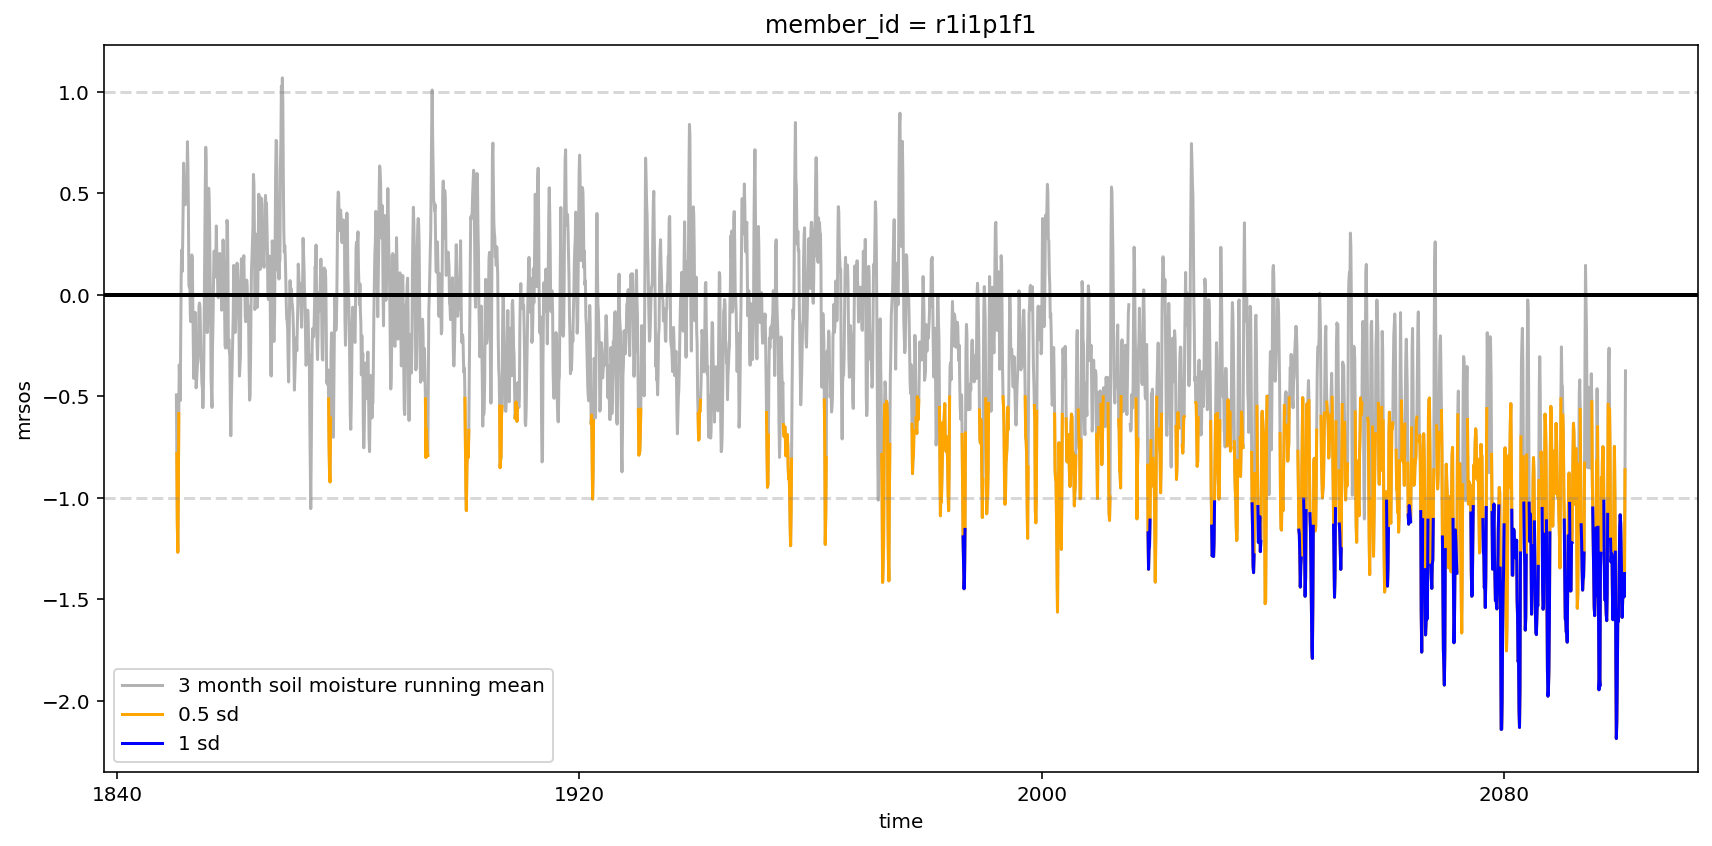

In [39]:
model_anoms_r['BCC-CSM2-MR']['r1i1p1f1'].plot(color = 'k', alpha = 0.3, label = '3 month soil moisture running mean')


model_anoms_r['BCC-CSM2-MR']['r1i1p1f1'].where(model_anoms_r['BCC-CSM2-MR']['r1i1p1f1']['point5_sd']).plot(color = 'orange', label = '0.5 sd')
model_anoms_r['BCC-CSM2-MR']['r1i1p1f1'].where(model_anoms_r['BCC-CSM2-MR']['r1i1p1f1']['one_sd']).plot(color = 'blue', label = "1 sd")


# 0 Line
plt.axhline(y = 0, color='k', linestyle='-', linewidth = 2)
plt.axhline(y = 1, color='grey', linestyle='--', alpha = 0.3)
plt.axhline(y = -1, color='grey', linestyle='--', alpha = 0.3)
    
plt.legend()

plt.tight_layout()

In [40]:
model_anoms_r['BCC-CSM2-MR'].keys()

dict_keys(['r1i1p1f1', 'r3i1p1f1', 'r2i1p1f1', 'r1i1p2f1', 'r3i1p2f1', 'r2i1p2f1'])

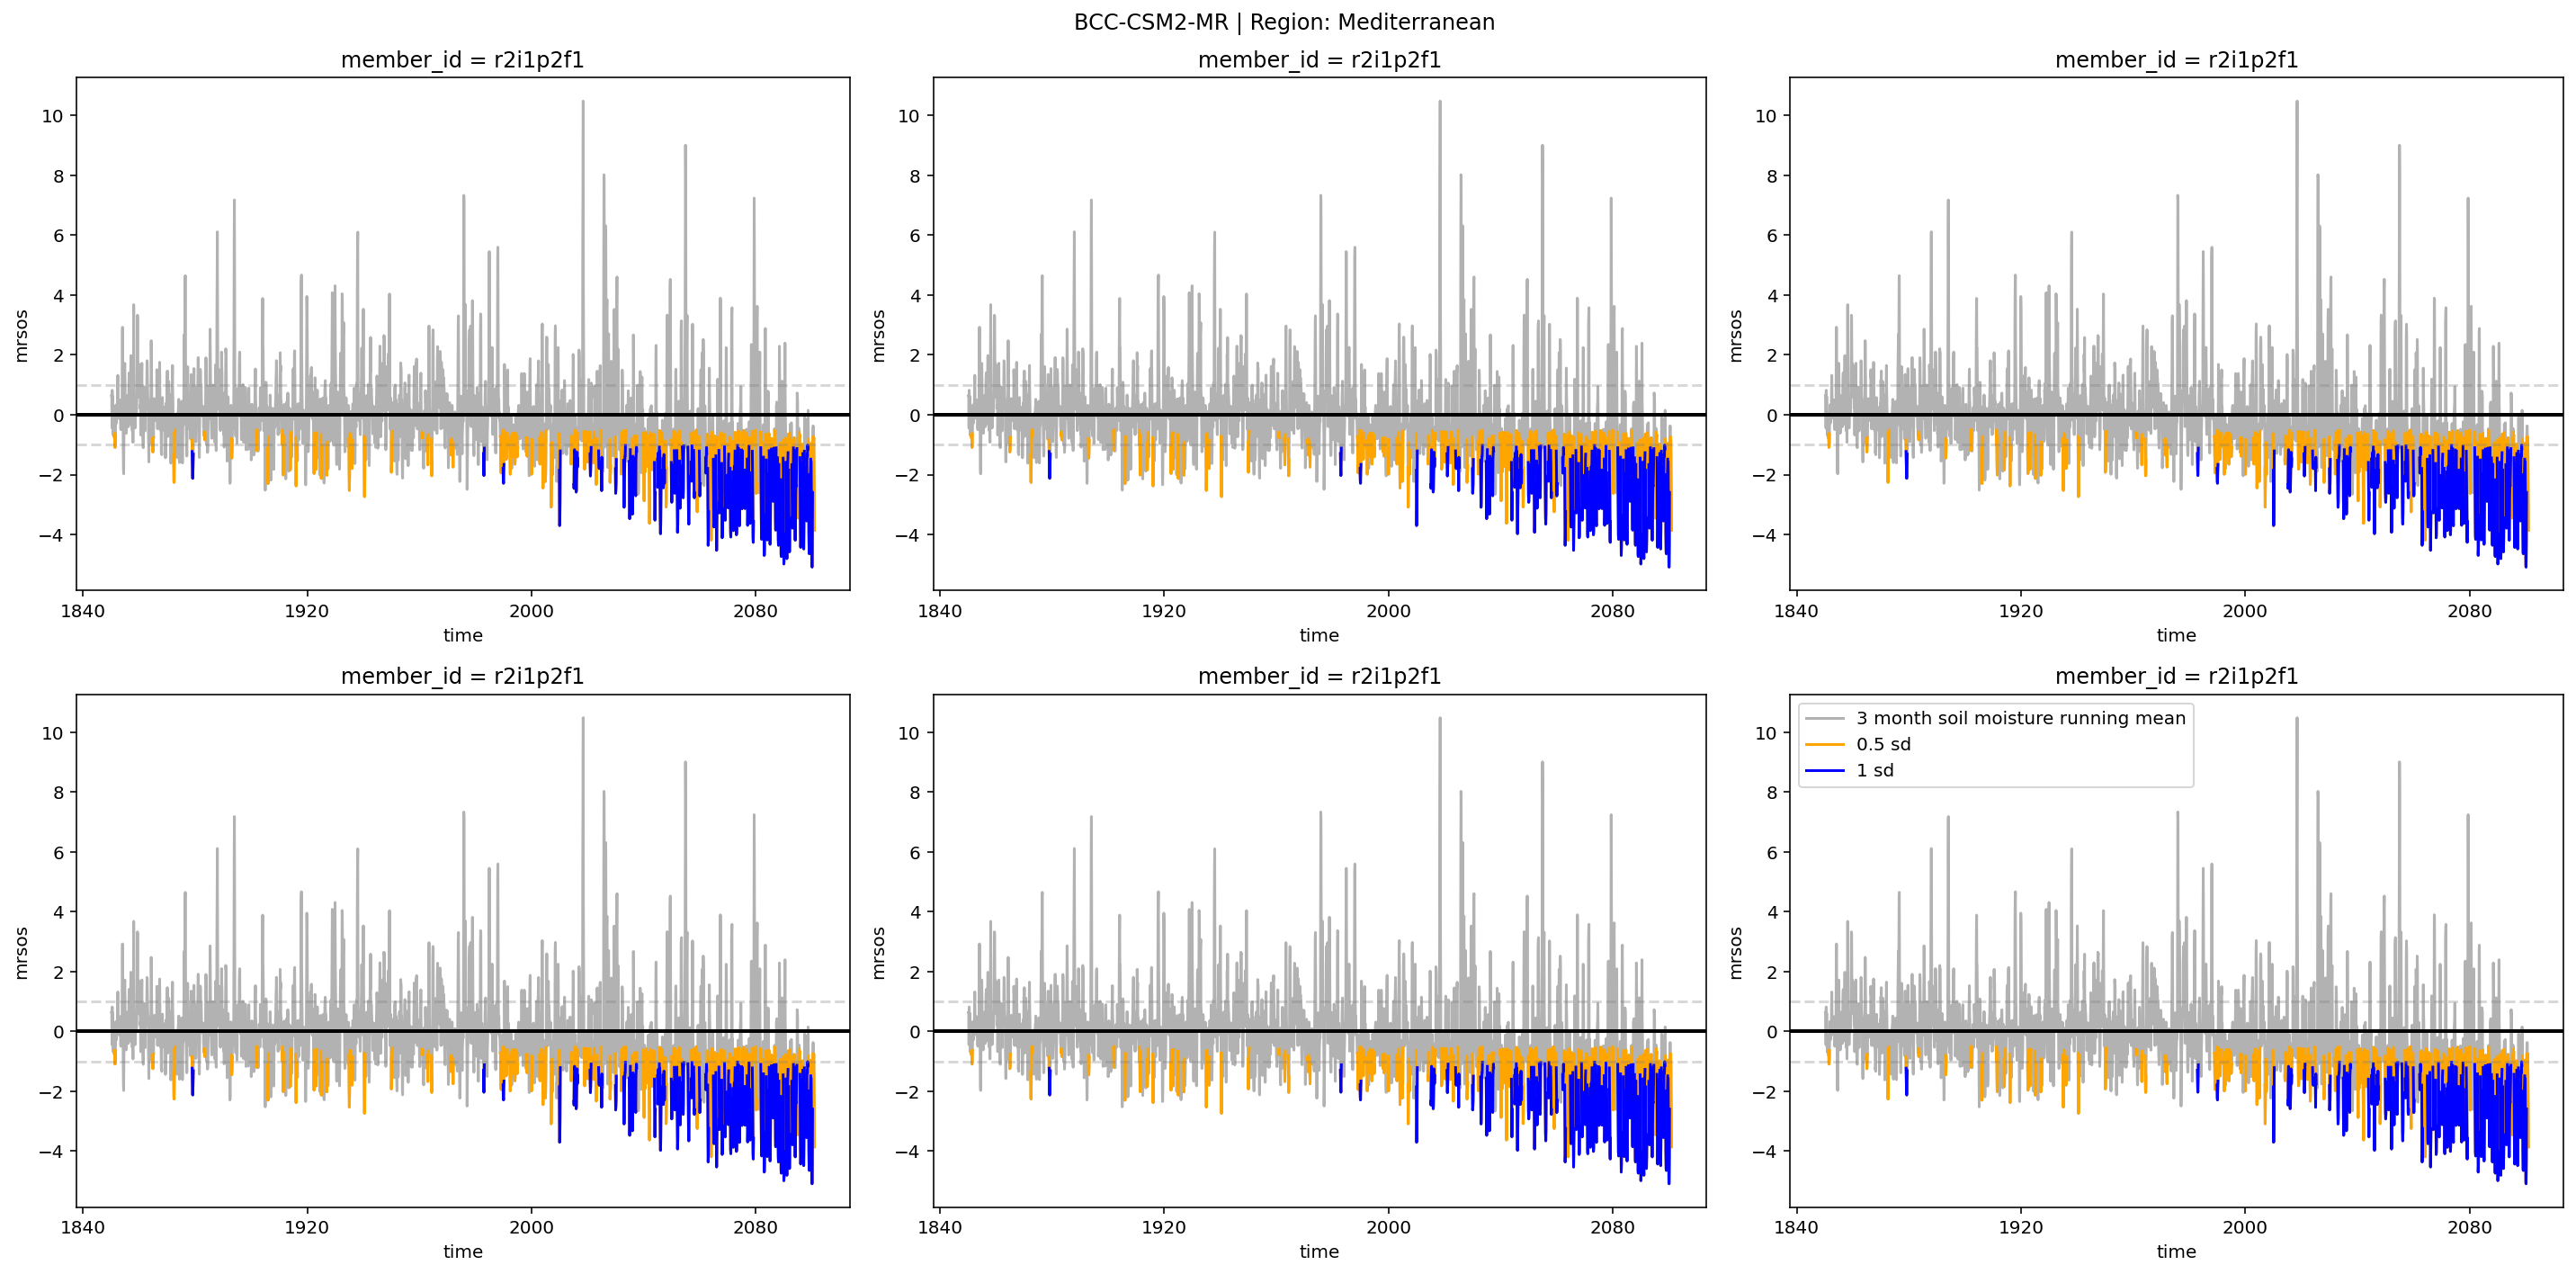

In [49]:

nrows = 2
ncols = 3

fig, axarr = plt.subplots(nrows = nrows, ncols = ncols, figsize = [20, 10])

for ax, model in zip(axarr.flat, model_anoms_r['BCC-CSM2-MR'].keys()):

#for ax, member_id in zip(axarr.flat, model_anoms_r['BCC-CSM2-MR'].keys()):
    model_anoms_r['BCC-CSM2-MR'][member_id].plot(color = 'k', alpha = 0.3, label = '3 month soil moisture running mean', ax = ax)


    model_anoms_r['BCC-CSM2-MR'][member_id].where(model_anoms_r['BCC-CSM2-MR'][member_id]['point5_sd']).plot(color = 'orange', label = '0.5 sd', ax = ax)
    model_anoms_r['BCC-CSM2-MR'][member_id].where(model_anoms_r['BCC-CSM2-MR'][member_id]['one_sd']).plot(color = 'blue', label = "1 sd", ax = ax)


    # 0 Line
    ax.axhline(y = 0, color='k', linestyle='-', linewidth = 2)
    ax.axhline(y = 1, color='grey', linestyle='--', alpha = 0.3)
    ax.axhline(y = -1, color='grey', linestyle='--', alpha = 0.3)
    
plt.legend()
plt.suptitle('BCC-CSM2-MR | Region: Mediterranean ')
plt.tight_layout()


the mary csv doesn't match up with the files available in the raw data file on dester, so I had to drop a few 

In [300]:
get_members('ACCESS-ESM1-5')

array(['r1i1p1f1', 'r2i1p1f1', 'r3i1p1f1', 'r6i1p1f1', 'r9i1p1f1',
       'r4i1p1f1', 'r7i1p1f1', 'r8i1p1f1', 'r5i1p1f1', 'r10i1p1f1',
       'r13i1p1f1', 'r15i1p1f1', 'r19i1p1f1', 'r17i1p1f1', 'r12i1p1f1',
       'r11i1p1f1', 'r16i1p1f1', 'r14i1p1f1', 'r18i1p1f1', 'r20i1p1f1',
       'r28i1p1f1', 'r26i1p1f1', 'r27i1p1f1', 'r22i1p1f1', 'r30i1p1f1',
       'r23i1p1f1', 'r21i1p1f1', 'r25i1p1f1', 'r29i1p1f1', 'r24i1p1f1'],
      dtype=object)

In [302]:
ddict_test['ACCESS-ESM1-5'].keys()

dict_keys(['r1i1p1f1', 'r2i1p1f1', 'r3i1p1f1', 'r6i1p1f1', 'r9i1p1f1', 'r4i1p1f1', 'r7i1p1f1', 'r8i1p1f1', 'r5i1p1f1', 'r10i1p1f1'])

In [303]:
r13 = xr.open_mfdataset(get_filenames('ACCESS-ESM1-5','r13i1p1f1'), preprocess = preprocess_dims)

IndexError: list index out of range

In [308]:
ingrid_cmip6[(ingrid_cmip6.member_id == 'r13i1p1f1') & (ingrid_cmip6.source_id == 'ACCESS-ESM1-5')]

,activity_id,experiment_id,file_basename,file_dirname,file_fullpath,grid_label,institution_id,member_id,mip_era,source_id,table_id,time_range,variable_id,tracking_id,version
229163,CMIP,historical,areacella_fx_ACCESS-ESM1-5_historical_r13i1p1f...,/m4/haibo/CMIP6mon/CMIP/CSIRO/ACCESS-ESM1-5/hi...,/m4/haibo/CMIP6mon/CMIP/CSIRO/ACCESS-ESM1-5/hi...,gn,CSIRO,r13i1p1f1,CMIP6,ACCESS-ESM1-5,fx,fixed,areacella,NaN,v20200803
395750,CMIP,historical,mrsol_Emon_ACCESS-ESM1-5_historical_r13i1p1f1_...,/dm10/haibo/CMIP6mon/CMIP/CSIRO/ACCESS-ESM1-5/...,/dm10/haibo/CMIP6mon/CMIP/CSIRO/ACCESS-ESM1-5/...,gn,CSIRO,r13i1p1f1,CMIP6,ACCESS-ESM1-5,Emon,185001-194912,mrsol,NaN,v20200803
395753,CMIP,historical,mrsol_Emon_ACCESS-ESM1-5_historical_r13i1p1f1_...,/dm10/haibo/CMIP6mon/CMIP/CSIRO/ACCESS-ESM1-5/...,/dm10/haibo/CMIP6mon/CMIP/CSIRO/ACCESS-ESM1-5/...,gn,CSIRO,r13i1p1f1,CMIP6,ACCESS-ESM1-5,Emon,195001-201412,mrsol,NaN,v20200803
717057,CMIP,historical,siextents_SImon_ACCESS-ESM1-5_historical_r13i1...,/dm12/haibo/CMIP6mon/CMIP/CSIRO/ACCESS-ESM1-5/...,/dm12/haibo/CMIP6mon/CMIP/CSIRO/ACCESS-ESM1-5/...,gn,CSIRO,r13i1p1f1,CMIP6,ACCESS-ESM1-5,SImon,185001-201412,siextents,NaN,v20200817
810021,CMIP,historical,tasmin_Amon_ACCESS-ESM1-5_historical_r13i1p1f1...,/dm3/haibo/CMIP6mon/CMIP/CSIRO/ACCESS-ESM1-5/h...,/dm3/haibo/CMIP6mon/CMIP/CSIRO/ACCESS-ESM1-5/h...,gn,CSIRO,r13i1p1f1,CMIP6,ACCESS-ESM1-5,Amon,185001-201412,tasmin,NaN,v20200803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991235,CMIP,historical,va_Amon_ACCESS-ESM1-5_historical_r13i1p1f1_gn_...,/dm1/haibo/CMIP6mon/CMIP/CSIRO/ACCESS-ESM1-5/h...,/dm1/haibo/CMIP6mon/CMIP/CSIRO/ACCESS-ESM1-5/h...,gn,CSIRO,r13i1p1f1,CMIP6,ACCESS-ESM1-5,Amon,195001-201412,va,NaN,v20200803
991237,CMIP,historical,va_Amon_ACCESS-ESM1-5_historical_r13i1p1f1_gn_...,/dm1/haibo/CMIP6mon/CMIP/CSIRO/ACCESS-ESM1-5/h...,/dm1/haibo/CMIP6mon/CMIP/CSIRO/ACCESS-ESM1-5/h...,gn,CSIRO,r13i1p1f1,CMIP6,ACCESS-ESM1-5,Amon,185001-194912,va,NaN,v20200803
991246,CMIP,historical,evspsbl_Amon_ACCESS-ESM1-5_historical_r13i1p1f...,/dm1/haibo/CMIP6mon/CMIP/CSIRO/ACCESS-ESM1-5/h...,/dm1/haibo/CMIP6mon/CMIP/CSIRO/ACCESS-ESM1-5/h...,gn,CSIRO,r13i1p1f1,CMIP6,ACCESS-ESM1-5,Amon,185001-201412,evspsbl,NaN,v20200803
991291,CMIP,historical,hur_Amon_ACCESS-ESM1-5_historical_r13i1p1f1_gn...,/dm1/haibo/CMIP6mon/CMIP/CSIRO/ACCESS-ESM1-5/h...,/dm1/haibo/CMIP6mon/CMIP/CSIRO/ACCESS-ESM1-5/h...,gn,CSIRO,r13i1p1f1,CMIP6,ACCESS-ESM1-5,Amon,195001-201412,hur,NaN,v20200803


In [304]:
get_filenames('ACCESS-ESM1-5','r13i1p1f1')

[[], [], [], [], [], []]

In [289]:
model = "ACCESS-CM2"

member_ids = get_members(model)
for member_id in member_ids:
    fnames = get_filenames(model, member_id)
    ddict_test[model][member_id] = xr.open_mfdataset(fnames, preprocess = preprocess_dims)

IndexError: list index out of range

             __.-/|
             \`o_O'
              =( )=  +------------------+
                U|   | here be dragons  |
      /\  /\   / |   +------------------+
     ) /^\) ^\/ _)\     |
     )   /^\/   _) \    |
     )   _ /  / _)  \___|_
 /\  )/\/ ||  | )_)\___,|))
<  >      |(,,) )__)    |
 ||      /    \)___)\
 | \____(      )___) )____
  \______(_______;;;)__;;;)

In [67]:
variable = 'tas'
experiment = 'historical'

ddict_test = dict.fromkeys(models, {})
for model in ddict_test.keys():
    member_ids = get_members(model, variable)
    print(member_ids)


['r1i1p1f1' 'r2i1p1f1' 'r3i1p1f1' 'r6i1p1f1' 'r9i1p1f1' 'r4i1p1f1'
 'r8i1p1f1' 'r7i1p1f1' 'r5i1p1f1' 'r10i1p1f1' 'r11i1p1f1' 'r24i1p1f1'
 'r29i1p1f1' 'r21i1p1f1' 'r28i1p1f1' 'r27i1p1f1' 'r25i1p1f1' 'r19i1p1f1'
 'r26i1p1f1' 'r13i1p1f1' 'r15i1p1f1' 'r17i1p1f1' 'r12i1p1f1' 'r16i1p1f1'
 'r14i1p1f1' 'r18i1p1f1' 'r20i1p1f1' 'r22i1p1f1' 'r30i1p1f1' 'r23i1p1f1']
['r1i1p1f1' 'r3i1p1f1' 'r2i1p1f1']
['r1i1p2f1' 'r2i1p2f1' 'r3i1p2f1']
['r1i1p1f1' 'r3i1p1f1' 'r2i1p1f1' 'r5i1p1f1' 'r4i1p1f1']
['r3i1p1f1' 'r1i1p1f1' 'r2i1p1f1' 'r1i1p2f1' 'r3i1p2f1' 'r2i1p2f1']
['r2i1p1f2' 'r1i1p1f2' 'r3i1p1f2' 'r7i1p1f2' 'r10i1p1f2' 'r6i1p1f2'
 'r4i1p1f2' 'r5i1p1f2' 'r8i1p1f2' 'r9i1p1f2' 'r19i1p1f2' 'r21i1p1f2'
 'r20i1p1f2' 'r13i1p1f2' 'r12i1p1f2' 'r26i1p1f2' 'r25i1p1f2' 'r11i1p1f2'
 'r27i1p1f2' 'r16i1p1f2' 'r28i1p1f2' 'r17i1p1f2' 'r29i1p1f2' 'r24i1p1f2'
 'r30i1p1f2' 'r14i1p1f2' 'r22i1p1f2' 'r18i1p1f2' 'r15i1p1f2' 'r23i1p1f2'
 'r1i1000p1f2']
['r1i1p1f2' 'r4i1p1f2' 'r8i1p1f2' 'r2i1p1f2' 'r3i1p1f2' 'r5i1p1f3'
 'r9i1p1f

ACCESS-ESM1-5
BCC-CSM2-MR
CanESM5-CanOE
CESM2-WACCM
FIO-ESM-2-0
MIROC-ES2L
UKESM1-0-LL
ACCESS-CM2
CAMS-CSM1-0


In [6]:
ddict_mrsos = model_import(models, 'mrsos', experiments)

  0%|          | 0/9 [00:00<?, ?it/s]

starting ACCESS-ESM1-5
starting BCC-CSM2-MR
starting CanESM5-CanOE
starting CESM2-WACCM
starting FIO-ESM-2-0
starting MIROC-ES2L
starting UKESM1-0-LL
starting ACCESS-CM2
starting CAMS-CSM1-0


In [37]:
ddict_pr = model_import(models, 'pr', experiments)

  0%|          | 0/9 [00:00<?, ?it/s]

starting ACCESS-ESM1-5
starting BCC-CSM2-MR
starting CanESM5-CanOE
starting CESM2-WACCM
starting FIO-ESM-2-0
starting MIROC-ES2L
starting UKESM1-0-LL
starting ACCESS-CM2
starting CAMS-CSM1-0


In [15]:
ddict_tas = model_import(models, 'tas', experiments)

  0%|          | 0/9 [00:00<?, ?it/s]

starting ACCESS-ESM1-5
starting BCC-CSM2-MR
starting CanESM5-CanOE
starting CESM2-WACCM
starting FIO-ESM-2-0
starting MIROC-ES2L
starting UKESM1-0-LL
starting ACCESS-CM2
starting CAMS-CSM1-0


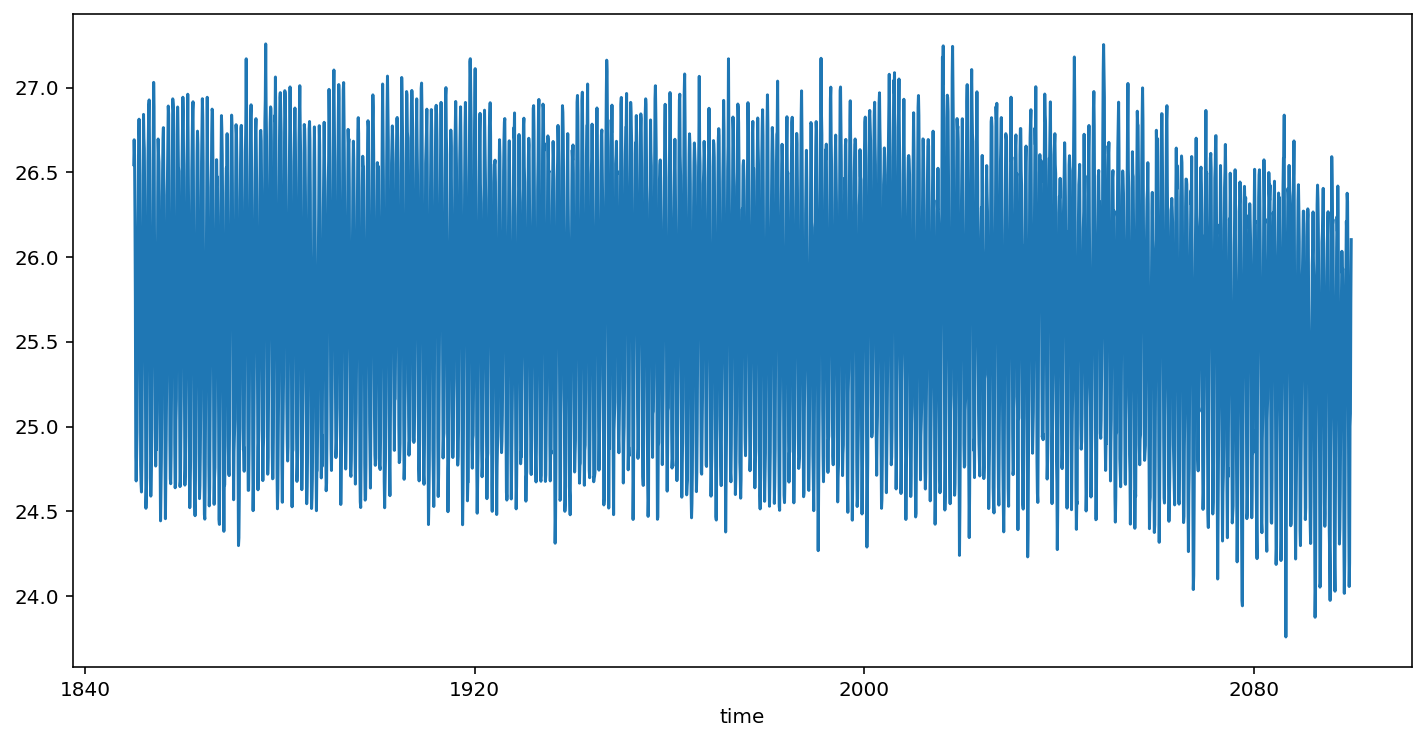

In [37]:
# testing out that it worked
global_mean(ddict_mrsos['CAMS-CSM1-0'].mean(dim = 'member_id').mrsos).plot()

In [42]:
ddict_tas['CAMS-CSM1-0']

,Array,Chunk
Bytes,38.40 MB,61.44 kB
Shape,"(3000, 5, 160, 2)","(24, 1, 160, 2)"
Count,11569 Tasks,1245 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,76.80 MB,122.88 kB
Shape,"(3000, 5, 320, 2)","(24, 1, 320, 2)"
Count,11569 Tasks,1245 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


In [40]:
ddict_mrsos['CAMS-CSM1-0']

,Array,Chunk
Bytes,23.04 MB,61.44 kB
Shape,"(3000, 3, 160, 2)","(24, 1, 160, 2)"
Count,7234 Tasks,747 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,46.08 MB,122.88 kB
Shape,"(3000, 3, 320, 2)","(24, 1, 320, 2)"
Count,7234 Tasks,747 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


In [38]:
xr.merge([ddict_mrsos['CAMS-CSM1-0'], ddict_tas['CAMS-CSM1-0']], compat = 'override')

ValueError: cannot reindex or align along dimension 'member_id' because the index has duplicate values

In [16]:
ddict_concat = {}

for model in tqdm(models):
    print('starting ' + model)

    ddict_concat[model] = xr.merge([ddict_mrsos[model], ddict_tas[model], ddict_pr[model]])

  0%|          | 0/9 [00:00<?, ?it/s]

starting ACCESS-ESM1-5


ValueError: cannot reindex or align along dimension 'member_id' because the index has duplicate values

In [5]:
def make_dataframe():
    #allvariables=['tas', 'mrro', 'mrros', 'mrso', "mrsos",'pr', 'evspsbl', 'prsn']
    #experiments=["piControl","historical","ssp126","ssp585","ssp370","ssp245"]
    
    #allvariables = ['mrsos', 'tas', 'pr']
    #experiments = ['historical', 'ssp126', 'ssp585']
    d={}
    d["filename"]=[]
    d["model"]=[]
    d["variable"]=[]
    d["member_id"]=[]
    d["experiment"]=[]

    for variable in variables:
        direc = get_rawdir(variable)
        models=sorted(os.listdir(direc))

        for model in models:
            for experiment in experiments:
                filenames=glob.glob(direc+model+"/*."+experiment+".*")
                for fname in filenames:
                    d["filename"]+=[fname]
                    d["model"]+=[model]
                    d["variable"]+=[variable]
                    d["member_id"]+=[fname.split(".")[3]]
                    d["experiment"]+=[experiment]
    df=pd.DataFrame(d)
    return df

In [6]:
df = make_dataframe()

In [7]:
df

,filename,model,variable,member_id,experiment
0,/home/kdm2144/DROUGHT/DOWNLOADED_RAW/mrsos/ACC...,ACCESS-CM2,mrsos,r1i1p1f1,historical
1,/home/kdm2144/DROUGHT/DOWNLOADED_RAW/mrsos/ACC...,ACCESS-CM2,mrsos,r2i1p1f1,historical
2,/home/kdm2144/DROUGHT/DOWNLOADED_RAW/mrsos/ACC...,ACCESS-CM2,mrsos,r2i1p1f1,historical
3,/home/kdm2144/DROUGHT/DOWNLOADED_RAW/mrsos/ACC...,ACCESS-CM2,mrsos,r1i1p1f1,historical
4,/home/kdm2144/DROUGHT/DOWNLOADED_RAW/mrsos/ACC...,ACCESS-CM2,mrsos,r2i1p1f1,historical
...,...,...,...,...,...
253406,/home/kdm2144/DROUGHT/DOWNLOADED_RAW/pr/UKESM1...,UKESM1-0-LL,pr,r2i1p1f2,ssp585
253407,/home/kdm2144/DROUGHT/DOWNLOADED_RAW/pr/UKESM1...,UKESM1-0-LL,pr,r2i1p1f2,ssp585
253408,/home/kdm2144/DROUGHT/DOWNLOADED_RAW/pr/UKESM1...,UKESM1-0-LL,pr,r1i1p1f2,ssp585
253409,/home/kdm2144/DROUGHT/DOWNLOADED_RAW/pr/UKESM1...,UKESM1-0-LL,pr,r1i1p1f2,ssp585


In [135]:
# make arrays of models and member_ids for later use
models = df.model.unique()
member_ids = df.member_id.unique()

In [ ]:
# make a dictionary to hold all the data for easy iteration and plotting
dset_dict = {}
for model in models:
    dset_dict[model] = {}
    #for variable in variables:
    #    dset_dict[model] 

In [107]:
#experiment = ["historical", 'ssp585']
variable = "mrsos"
model = "ACCESS-CM2"

rawdir = "/home/kdm2144/DROUGHT/DOWNLOADED_RAW/"+variable+"/"

In [108]:
#member = "r1i1p1f1"

In [109]:
#glob.glob(rawdir+model+"/"+variable+"."+experiment+"."+model+"."+ member + "*")

[]

In [119]:
tmp = {}

for experiment in tqdm(experiments):
    #for model in models:
    member_ids = get_members(model, variable, experiment)
    for member in member_ids:
        tmp[member] = xr.open_mfdataset(glob.glob(rawdir+model+'/' + variable +'.'+ experiment + '.' + model + '.'+ member + '*'), 
                                        preprocess = fix_dims).assign_coords(member_id = member, experiment = experiment) 

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
fname = []


for experiment in tqdm(experiments):
    #for model in models:

member_ids = get_members(model, variable, experiment)
for member in member_ids:
    fname.append(glob.glob(rawdir+model+'/' + variable +'.'+ experiment + '.' + model + '.' + member + '*'))
    
boop = xr.open_mfdataset(fname, combine = 'nested', concat_dim = ['member_id', 'time'],  
                         preprocess = fix_dims).assign_coords(member_id = member_ids)

In [180]:
variables = ['mrsos', 'pr', 'tas']
experiments = ['historical', 'ssp585']
models = ['ACCESS-CM2', 'CanESM5']

fname = []
#for variable in variables:
for experiment in experiments:
    member_ids = get_members(model, variable, experiment)
    for member in member_ids:
        fname.append(glob.glob(rawdir+model+'/' + variable +'.'+ experiment + '.' + model + '.' + member + '*'))

boop = xr.open_mfdataset(fname, combine = 'nested', concat_dim = ['experiment', 'member_id', 'time'],  
                         preprocess = fix_dims).assign_coords(member_id = member_ids)

ValueError: The supplied objects do not form a hypercube because sub-lists do not have consistent lengths along dimension0

In [184]:

boop = xr.open_mfdataset(glob.glob(rawdir+model+'/' + variable +'.'+ experiment + '.' + model + '*'),  
                         preprocess = preprocess_dims)

TypeError: preprocess_dims() missing 1 required positional argument: 'member_ids'

In [210]:
ds = xr.open_mfdataset(rawdir + 'ACCESS-CM2/mrsos.historical.ACCESS-CM2.r1i1p1f1.1850.nc', preprocess = preprocess_dims)

In [211]:
ds

<xarray.Dataset>
Dimensions:     (bound: 2, lat: 144, lon: 192, time: 12)
Coordinates:
  * time        (time) datetime64[ns] 1850-01-16T12:00:00 ... 1850-12-16T12:0...
  * lat         (lat) float32 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
  * lon         (lon) float32 0.9375 2.812 4.688 6.562 ... 355.3 357.2 359.1
    member_id   <U8 'r1i1p1f1'
    experiment  <U10 'historical'
Dimensions without coordinates: bound
Data variables:
    lat_bnds    (lat, bound) float64 dask.array<chunksize=(144, 2), meta=np.ndarray>
    lon_bnds    (lon, bound) float64 dask.array<chunksize=(192, 2), meta=np.ndarray>
    mrsos       (time, lat, lon) float32 dask.array<chunksize=(12, 144, 192), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.0

In [126]:
tmp['r1i1p1f1']


<xarray.Dataset>
Dimensions:     (bound: 2, lat: 144, lon: 192, time: 1032)
Coordinates:
  * time        (time) datetime64[ns] 2015-01-16T12:00:00 ... 2100-12-16T12:0...
  * lat         (lat) float32 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
  * lon         (lon) float32 0.9375 2.812 4.688 6.562 ... 355.3 357.2 359.1
    member_id   <U8 'r1i1p1f1'
    experiment  <U6 'ssp585'
Dimensions without coordinates: bound
Data variables:
    lat_bnds    (time, lat, bound) float64 dask.array<chunksize=(12, 144, 2), meta=np.ndarray>
    lon_bnds    (time, lon, bound) float64 dask.array<chunksize=(12, 192, 2), meta=np.ndarray>
    mrsos       (time, lat, lon) float32 dask.array<chunksize=(12, 144, 192), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.0

In [127]:
test = xr.combine_nested([tmp['r1i1p1f1'],tmp['r2i1p1f1']], concat_dim = 'time')

In [131]:
test.mrsos

<xarray.DataArray 'mrsos' (time: 3012, lat: 144, lon: 192)>
dask.array<concatenate, shape=(3012, 144, 192), dtype=float32, chunksize=(12, 144, 192), chunktype=numpy.ndarray>
Coordinates:
  * time        (time) datetime64[ns] 2015-01-16T12:00:00 ... 2014-12-16T12:0...
  * lat         (lat) float32 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
  * lon         (lon) float32 0.9375 2.812 4.688 6.562 ... 355.3 357.2 359.1
    member_id   (time) <U8 'r1i1p1f1' 'r1i1p1f1' ... 'r2i1p1f1' 'r2i1p1f1'
    experiment  (time) <U10 'ssp585' 'ssp585' ... 'historical' 'historical'
Attributes:
    history:        2019-11-08T07:21:50Z altered by CMOR: Treated scalar dime...
    coordinates:    depth
    long_name:      Moisture in Upper Portion of Soil Column
    standard_name:  mass_content_of_water_in_soil_layer
    cell_measures:  area: areacella
    units:          kg m-2
    cell_methods:   area: mean where land time: mean
    comment:        The mass of water in all phases in the upper 10cm of the ...

test.member_

In [14]:
#tmp.load()

In [15]:
#global_mean(tmp).mrsos.plot()

In [82]:
test = {}

for experiment in tqdm(experiments):
    print(experiment)
    for variable in variables:
        print(variable)
        #rawdir = get_rawdir(variable)
        rawdir = "/home/kdm2144/DROUGHT/DOWNLOADED_RAW/"+variable+"/"
            #for model in models:
            member_ids = get_members(model, variable, experiment)
            #print(model + ":" + member_ids)
            for member in member_ids:
                test[member] = xr.open_mfdataset(glob.glob(rawdir+model+'/' + variable +'.'+ experiment + '.' + model + member + '*'), preprocess = fix_dims)
                #test = xr.open_mfdataset(glob.glob(rawdir+model+"/"+variable+"."+experiment+"."+model+"."+member+".*"), preprocess = fix_dims)



  0%|          | 0/3 [00:00<?, ?it/s]

historical
mrsos
['E3SM-1-0:r1i1p1f1' 'E3SM-1-0:r2i1p1f1' 'E3SM-1-0:r3i1p1f1'
 'E3SM-1-0:r4i1p1f1' 'E3SM-1-0:r5i1p1f1']
tas
['E3SM-1-0:r1i1p1f1' 'E3SM-1-0:r2i1p1f1' 'E3SM-1-0:r3i1p1f1'
 'E3SM-1-0:r4i1p1f1' 'E3SM-1-0:r5i1p1f1']
pr
['E3SM-1-0:r1i1p1f1' 'E3SM-1-0:r2i1p1f1' 'E3SM-1-0:r3i1p1f1'
 'E3SM-1-0:r4i1p1f1' 'E3SM-1-0:r5i1p1f1']
ssp126
mrsos
[]
tas
[]
pr
[]
ssp585
mrsos
[]
tas
[]
pr
[]


In [ ]:
xr.open_mfdataset

In [ ]:
#things are opening properly, but now need to make sure models and ensemble members stay seperated 

In [57]:
test = xr.open_mfdataset(df.filename[0:10], preprocess = fix_dims, combine="by_coords")

In [56]:
test.mrsos

<xarray.DataArray 'mrsos' (time: 1020, lat: 144, lon: 192)>
dask.array<concatenate, shape=(1020, 144, 192), dtype=float32, chunksize=(12, 144, 192), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1851-01-16T12:00:00 ... 2013-12-16T12:00:00
  * lat      (lat) float32 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
  * lon      (lon) float32 0.9375 2.812 4.688 6.562 ... 353.4 355.3 357.2 359.1
Attributes:
    history:        2019-11-25T08:12:51Z altered by CMOR: Treated scalar dime...
    long_name:      Moisture in Upper Portion of Soil Column
    standard_name:  mass_content_of_water_in_soil_layer
    coordinates:    depth
    cell_methods:   area: mean where land time: mean
    units:          kg m-2
    cell_measures:  area: areacella
    comment:        The mass of water in all phases in the upper 10cm of the ...

In [ ]:
model_dict = {}

In [161]:
model = "ACCESS-CM2"
member = "r1i1p1f1"
experiment = "historical"

fname = []

member_ids = get_members(model, variable, experiment)
for member in member_ids:
    fname.append(glob.glob(rawdir+model+'/' + variable +'.'+ experiment + '.' + model + '.' + member + '*'))
    
boop = xr.open_mfdataset(fname, combine = 'nested', concat_dim = ['member_id', 'time'],  
                         preprocess = fix_dims).assign_coords(member_id = member_ids)

In [177]:
boop = xr.open_mfdataset(fname, combine = 'nested', concat_dim = ['member_id', 'time'],  
                         preprocess = fix_dims).assign_coords(member_id = member_ids)

In [158]:
#fname

In [178]:
boop

,Array,Chunk
Bytes,18.14 MB,55.30 kB
Shape,"(3936, 2, 144, 2)","(24, 1, 144, 2)"
Count,1980 Tasks,330 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,24.18 MB,73.73 kB
Shape,"(3936, 2, 192, 2)","(24, 1, 192, 2)"
Count,1980 Tasks,330 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


In [172]:
boop

,Array,Chunk
Bytes,18.14 MB,55.30 kB
Shape,"(3936, 2, 144, 2)","(24, 1, 144, 2)"
Count,1980 Tasks,330 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,24.18 MB,73.73 kB
Shape,"(3936, 2, 192, 2)","(24, 1, 192, 2)"
Count,1980 Tasks,330 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


In [142]:
model = "ACCESS-CM2"
member = "r1i1p1f1"
experiment = "historical"

boop = xr.open_mfdataset(glob.glob(rawdir+model+'/' + variable +'.'+ experiment + '.' + model + '.*'), preprocess = fix_dims)

<xarray.Dataset>
Dimensions:   (bound: 2, lat: 144, lon: 192, time: 1980)
Coordinates:
  * time      (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
  * lat       (lat) float32 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
  * lon       (lon) float32 0.9375 2.812 4.688 6.562 ... 353.4 355.3 357.2 359.1
Dimensions without coordinates: bound
Data variables:
    lat_bnds  (time, lat, bound) float64 dask.array<chunksize=(12, 144, 2), meta=np.ndarray>
    lon_bnds  (time, lon, bound) float64 dask.array<chunksize=(12, 192, 2), meta=np.ndarray>
    mrsos     (time, lat, lon) float32 dask.array<chunksize=(12, 144, 192), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.0

In [144]:
model = "ACCESS-CM2"
experiment = "historical"
variable = "mrsos"

member_ids = get_members(model, variable, experiment)


In [145]:
member_ids

array(['r1i1p1f1', 'r2i1p1f1'], dtype=object)

In [150]:
xr.open_dataset(rawdir + '/ACCESS-CM2/mrsos.historical.ACCESS-CM2.r1i1p1f1.1863.nc')

<xarray.Dataset>
Dimensions:      (axis_841439: 12, bound: 2, lat: 144, lon: 192)
Coordinates:
  * axis_841439  (axis_841439) datetime64[ns] 1863-01-16T12:00:00 ... 1863-12...
  * lat          (lat) float32 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
  * lon          (lon) float32 0.9375 2.812 4.688 6.562 ... 355.3 357.2 359.1
Dimensions without coordinates: bound
Data variables:
    lat_bnds     (lat, bound) float64 ...
    lon_bnds     (lon, bound) float64 ...
    mrsos        (axis_841439, lat, lon) float32 ...
Attributes:
    Conventions:  CF-1.0